# NLPHW1 - Named Entity Recognition
Francesco Starna
1613660

## Setup
Imports.

In [ ]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.nn.utils import clip_grad_value_

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from collections import Counter
import csv, pickle

torch.manual_seed(1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

### Vocabulary
The class vocabulary it has been thought to create a general vocabulary where each word is lowered and lemmatize. nltk WordNet Lemmatizer is used to get lemma from plurals and verbs.

In [ ]:
class Vocab():

  def __init__(self, vocab_size, unk_token='<unk>', 
               path=None, tag_to_index=None, words=None, characters=None):

    self.unk_token = unk_token
    self.word_vocab_size = vocab_size[0]
    self.char_vocab_size = vocab_size[1]

    if path is None:
      self.__word_vocabulary, self.__char_vocabulary = words, characters
      self.tag_to_index = tag_to_index
    
    else:
      self.tag_to_index = {'O':0, 'PER':1, 'ORG':2, 'LOC':3, '<pad>':9, '<test>': 8}
      self.__word_vocabulary, self.__char_vocabulary = self.__build_vocabs(path)

  def characters(self):
    return self.__char_vocabulary

  def words(self):
    return self.__word_vocabulary

  def save(self, path):
    with open(path, 'wb') as f:
      obj = {'vocab_size' : (self.word_vocab_size, self.char_vocab_size),
             'tag_to_index': self.tag_to_index,
             'unk_token' : self.unk_token,
             'words' : self.words(),
             'characters' : self.characters()}
      pickle.dump(obj, f)

  @staticmethod
  def load(path):
    with open(path, 'rb') as f:
      obj = pickle.load(f)
      return Vocab(obj['vocab_size'],
                   unk_token=obj['unk_token'], 
                   tag_to_index=obj['tag_to_index'],  
                   words=obj['words'], 
                   characters=obj['characters'])

  def __build_vocabs(self, path):
    char_counter = Counter()
    word_counter = Counter()
    # simplifying vocabulary with lemma (plurals and verbs)
    l = WordNetLemmatizer()
    with open(path, 'r') as file:
      for line in file:
        if line[0] == '#':
          line = line.split()[1:]
          
          #populating word vocabulary
          for word in line:
            word = l.lemmatize(l.lemmatize(word,'v'))
            word_counter[word] += 1
              
            #populating character vocabulary
            for char in word:
              char_counter[char] += 1
        
        else: continue

    word_vocabulary = {key:index for index, (key,_) in enumerate(word_counter.most_common(self.word_vocab_size-2))}
    word_vocabulary[self.unk_token] = self.word_vocab_size-2
    word_vocabulary['<pad>'] = self.word_vocab_size-1
    char_vocabulary = {key:index for index, (key,_) in enumerate(char_counter.most_common(self.char_vocab_size-1))}
    char_vocabulary[self.unk_token] = self.char_vocab_size-1

    return word_vocabulary, char_vocabulary

In [ ]:
folder = '/content/drive/My Drive/AIRO/NLP/Homework/homework1/'
data_path = 'nlp2020-hw1/data/'
vocab_size = (20000,50) #(word_vocab_size, char_vocab_size)

vocab = Vocab(vocab_size, path=folder+data_path+'train.tsv')

**Saving the Vocabulary**

In [ ]:
vocab.save(folder+'vocab-word.pickle')

### Pretrained Embedding
The choice of using pretrained embeddings is crucial. The choice was Global Vectors from Standford Wikipedia 2014 + Gigaword 5 with 6B tokens and 50 vector size representation.

In [ ]:
class GloVe():

  def __init__(self, path):

    self.vector_dim = 100
    self.path = path
    self.vectors = self.__load_vectors()

  def __contains__(self, item):
    return item in self.vectors

  def __getitem__(self, item):
    return self.vectors[item] if item in self.vectors else None
                   
  def __load_vectors(self):
    vectors_dict = dict()
    with open(self.path, 'r') as glove:
      for line in glove:
        values = line.split()
        word = values[0]
        vector = [float(i) for i in values[1:]]
        vectors_dict[word] = vector
    return vectors_dict

In [ ]:
glove = GloVe(folder+"glove.6B.100d.txt") 

### Utility
The Encoder class takes care of encoding samples in PyTorch Tensor for feed the neural networks. It also has methods for read text samples and decode output after prediction. For this, it makes use of a Vocab.

In [ ]:
class Encoder():

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  l = WordNetLemmatizer()

  # sampling method for testing
  @staticmethod
  def read_test(sentence):
    sample = list()
    for w in sentence.split():      
      d = dict()
      d['word'] = w
      d['lemma'] = Encoder.l.lemmatize(Encoder.l.lemmatize(w,'v'))
      d['postag'] = '<test>'
      sample.append(d)
    return sample

  # returns the index of the word in the vocabulary
  @staticmethod
  def __word_2_index(word, v:Vocab):
    if word in v.words(): return v.words()[word]
    else: return v.words()[v.unk_token]

  @staticmethod
  def load_word_embeddings(v:Vocab, g:GloVe):
    embeddings = torch.randn(len(v.words()), g.vector_dim)
    for i, w in enumerate(v.words()):
      if w in g: embeddings[i] = torch.FloatTensor(g[w])
    return embeddings

  """
    input:  list of dictionaries each per word in sentence
    output: vocabulary in which
      encoded_words  -> Tensor of [indexes of words in a sample] + <PAD>
      encoded_labels -> Tensor of [index of postag] + <PAD>
  """
  @staticmethod
  def encode(sample, v:Vocab, max_s_len=0, max_ch_len=0):
    s_len = len(sample)
    if max_s_len == 0: max_s_len = s_len

    encoded_words = torch.LongTensor([Encoder.__word_2_index(w['lemma'], v) for w in sample]
                                     +[Encoder.__word_2_index('<pad>', v)]*(max_s_len-s_len)).to(Encoder.device)
    
    encoded_tags = torch.LongTensor([v.tag_to_index[w['postag']] for w in sample]
      +[v.tag_to_index['<pad>']]*(max_s_len-s_len)).to(Encoder.device)
    
    return {'inputs' : encoded_words, 'tags' : encoded_tags}

  # Decoding the prediction
  @staticmethod
  def decode(indices, v:Vocab):
    # reverse tag_to_index mapping in order to check output indices
    index_to_tag = {v:k for k,v in v.tag_to_index.items()}
    indices = indices.squeeze().tolist()
    if type(indices) is list: return [index_to_tag[tag] for tag in indices]
    else: return [index_to_tag[indices]]

In [ ]:
sample = [{'word':'home','lemma':'home','postag':'O'},{'word':'bellissima','lemma':'bellissima','postag':'ORG'}, {'word':'Francesco','lemma':'Francesco','postag':'<test>'}]

print('[DEVICE]', Encoder.device)
encoded_sample = Encoder.encode(sample, vocab, 5)
print(encoded_sample['inputs'].shape, encoded_sample['inputs'])
print(encoded_sample['tags'].shape, encoded_sample['tags'])

[DEVICE] cuda
torch.Size([5]) tensor([  160, 19998,  9307, 19999, 19999], device='cuda:0')
torch.Size([5]) tensor([0, 2, 8, 9, 9], device='cuda:0')


### Dataset
The class organizes input text and samples it using a dictionary for each word 

```
{'word':'word', 'lemma':'lemma of word', 'postag':'tag of word'}
```
It is subclass of IterabaleDataset, where the __ iter __ method returns inputs and tags encoding the dictionary representation of each sentence.

In [ ]:
class MyDataset(IterableDataset):

  def __init__(self, path, vocab:Vocab, test=False):

    # max lengths of sample for padding
    self.max_s_len = 0
    self.vocab = vocab
    self.path = path
    self.test = test
    self.__data = self.__build_dataset()

  def __len__(self):
    return len(self.__data)

  def __getitem__(self, index):
    return self.__data[index]

  """ 
    build list of lists of dictionaries
    sample --> [{word-1: _ , lemma-1: _ , postag-1: _ }...{word-n: _ , lemma-n: _ , postag-n: _ }]
  """
  def __build_dataset(self):
    data = list()
    with open(self.path, 'r') as file:

      for line in file:
        line = line.split()
        if len(line) == 0: continue
        elif line[0] == '#':
          count = len(line[1:])
          sample = list()

          for i in range(count):
            line = next(file).split()
            d = dict()
            d['word'] = line[1]
            d['lemma'] = Encoder.l.lemmatize(Encoder.l.lemmatize(line[1],'v'))
            d['postag'] = line[2]
            sample.append(d)

          if int(line[0]) > self.max_s_len: self.max_s_len = int(line[0])+1
          data.append(sample)

    return data

  # ecoded dataset 
  def __iter__(self):
    for i in range(len(self.__data)):
      if self.test: yield Encoder.encode(self.__data[i], self.vocab)
      else: yield Encoder.encode(self.__data[i], self.vocab, self.max_s_len)

In [ ]:
train_set = MyDataset(folder+data_path+'train.tsv', vocab)
dev_set = MyDataset(folder+data_path+'dev.tsv', vocab)

## Model

### Building
The Neural Network model is based on BiLSTM and make use of a dropout layer to prevent overfitting and finally returns a logits prediction where each one represent the probability of each class.


In [ ]:
class MyModel(nn.Module):

  def __init__(self, hparams):
    super(MyModel, self).__init__()

    # Word embedding
    self.word_embedding = nn.Embedding(hparams.word_vocab_size, hparams.word_embedding_dim)
    self.word_embedding.weight.data.copy_(hparams.word_embeddings)

    # Bidirectional LSTM 
    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim,
                        num_layers=hparams.num_layers,
                        bidirectional=True,
                        batch_first=True,
                        dropout = hparams.dropout if hparams.num_layers > 1 else 0)
    
    # dropout embedding
    self.dropout = nn.Dropout(hparams.dropout)
    
    # linear classifier
    self.classifier = nn.Linear(hparams.hidden_dim*2, hparams.num_tags)

  def forward(self, x):
    word_embedding = self.word_embedding(x)
    x = self.dropout(word_embedding)
    o, (_, _) = self.lstm(x)
    output = self.classifier(o)
    return output

### Hyperparameters

In [ ]:
class HParams():

  def __init__(self, v:Vocab, g:GloVe):

    # word
    self.word_vocab_size = v.word_vocab_size
    self.word_embedding_dim = g.vector_dim
    self.word_embeddings = Encoder.load_word_embeddings(v, g)

    # parameters
    self.embedding_dim = 100
    self.num_layers = 2
    self.hidden_dim = 128
    self.dropout = 0.1
    self.num_tags = len(v.tag_to_index)-2
    self.epochs = 10

params = HParams(vocab, glove)

## Training

In [ ]:
class Trainer():

  def __init__(self, model,loss_function, optimizer):
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self, train_dataset, valid_dataset, epochs=1):
    
    train_loss = 0.0
    
    for epoch in range(epochs):
      print(' Epoch {:03d}'.format(epoch + 1))

      # train mode
      self.model.train()

      epoch_loss = 0.0

      for step, sample in enumerate(train_dataset):
        inputs = sample['inputs']
        tags = sample['tags']
      
        self.optimizer.zero_grad()
        predictions = self.model(inputs)

        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
  
        sample_loss = self.loss_function(predictions, tags)
        sample_loss.backward()

        self.optimizer.step()

        epoch_loss += sample_loss.tolist()
      
      avg_epoch_loss = epoch_loss/len(train_dataset)
      train_loss += avg_epoch_loss
      print('\n\t[E: {:2d}] train loss = {:0.4f}'.format(epoch+1, avg_epoch_loss))

      valid_loss = self.evaluate(valid_dataset)
      print('\t[E: {:2d}] valid loss = {:0.4f}'.format(epoch+1, valid_loss))

    avg_epoch_loss = train_loss / epochs
    return avg_epoch_loss

  def evaluate(self, valid_dataset):
    valid_loss = 0.0
    
    # evaluation mode
    self.model.eval()

    with torch.no_grad():
      for sample in valid_dataset:

        inputs = sample['inputs']
        tags = sample['tags']
        
        predictions = self.model(inputs)
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        sample_loss = self.loss_function(predictions, tags)

        valid_loss += sample_loss.tolist()

    return valid_loss / len(valid_dataset)

  def predict(self, x):
    # evaluation mode
    self.model.eval()
    with torch.no_grad():
      inputs = x['inputs'].unsqueeze(0)
      logits = self.model(inputs)
      predictions = torch.argmax(logits, -1)
      return logits, predictions

In [ ]:
train_dataset = DataLoader(train_set, batch_size=128)
valid_dataset = DataLoader(dev_set, batch_size=128)

In [ ]:
postagger = MyModel(params).cuda() if Encoder.device == 'cuda' else MyModel(params)

trainer = Trainer(
    model = postagger,
    loss_function = nn.CrossEntropyLoss(ignore_index=vocab.tag_to_index['<pad>']),
    optimizer = optim.Adam(postagger.parameters())
)

In [ ]:
trainer.train(train_dataset, valid_dataset, params.epochs)

 Epoch 001

	[E:  1] train loss = 0.0013
	[E:  1] valid loss = 0.0008
 Epoch 002

	[E:  2] train loss = 0.0007
	[E:  2] valid loss = 0.0006
 Epoch 003

	[E:  3] train loss = 0.0005
	[E:  3] valid loss = 0.0006
 Epoch 004

	[E:  4] train loss = 0.0004
	[E:  4] valid loss = 0.0005
 Epoch 005

	[E:  5] train loss = 0.0004
	[E:  5] valid loss = 0.0005
 Epoch 006

	[E:  6] train loss = 0.0003
	[E:  6] valid loss = 0.0005
 Epoch 007

	[E:  7] train loss = 0.0003
	[E:  7] valid loss = 0.0005
 Epoch 008

	[E:  8] train loss = 0.0003
	[E:  8] valid loss = 0.0005
 Epoch 009

	[E:  9] train loss = 0.0002
	[E:  9] valid loss = 0.0006
 Epoch 010

	[E: 10] train loss = 0.0002
	[E: 10] valid loss = 0.0006


0.0004671261993944645

## Evaluation
Accuracy it is not a good estimator. In fact, even with high accuray, we could have low precision (due to unbalanced sets).

In [ ]:
test_set = MyDataset(folder+data_path+'test.tsv', vocab, test=True)
test_dataset = DataLoader(test_set, 1)
test_set_loss = trainer.evaluate(test_dataset)
print("test set loss: {}".format(test_set_loss))

test set loss: 0.07745758781232888


In [ ]:
count, tot_samples = 0,0
tags = dict.fromkeys(vocab.tag_to_index, 0)
del tags['<test>']
del tags['<pad>']
matrix = dict()
for tag in tags:
  matrix[tag] = tags.copy()
precision = dict()
recall = dict()

for sample in test_set:

  test_y = sample['tags']
  
  _, predictions = trainer.predict(sample)
  
  x_tags = Encoder.decode(predictions,vocab)
  y_tags = Encoder.decode(test_y,vocab)

  for x, y in zip(x_tags, y_tags):
    tot_samples += 1
    if x == y: 
      count += 1
    matrix[x][y] +=1  

for key in matrix:
  precision[key] = matrix[key][key]/sum([matrix[key][k] for k in matrix])
  recall[key] = matrix[key][key]/sum([matrix[k][key] for k in matrix])

print('[ACCURACY] =',count/tot_samples)
print('[PRECISION]','[RECALL]','[F1 SCORE]')
for tag in precision:
  f1_score = 2*precision[tag]*recall[tag]/(precision[tag]+recall[tag])
  print('{}\t{:0.2f}\t{:0.2f}\t{:0.2f}'.format(tag, precision[tag], recall[tag], f1_score))


[ACCURACY] = 0.9808521104920382
[PRECISION] [RECALL] [F1 SCORE]
O	0.99	0.99	0.99
PER	0.92	0.92	0.92
ORG	0.88	0.78	0.83
LOC	0.88	0.89	0.88


Confusion Matrix

[array([0.99032445, 0.00266932, 0.00398318, 0.00302305]), array([0.0549315 , 0.92136874, 0.01538861, 0.00831115]), array([0.07118525, 0.01162927, 0.88112299, 0.03606249]), array([0.06967243, 0.01181878, 0.04136573, 0.87714307])]


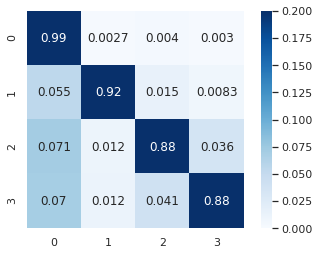

In [ ]:
import numpy as np
import matplotlib as plt
import seaborn as sns; sns.set()

confusion = dict()
for key in matrix:
  factor=1.0/sum(matrix[key].values())
  n = {k:v*factor for (k,v) in matrix[key].items()}
  confusion[key] = n

data = [np.array(list(d.values())) for d in confusion.values()]
ax = sns.heatmap(data, vmin=0, vmax=0.2, square=True, cmap='coolwarm', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Real')

## Prediction
A prediction method for testing every single sentence

In [ ]:
sentence = 'Francesco went with Lorenzo to London for studying at Cambridge University'
sample = Encoder.read_test(sentence)
encoded_sample = Encoder.encode(sample, vocab)
_, predictions = trainer.predict(encoded_sample)
Encoder.decode(predictions, vocab)

['PER', 'O', 'O', 'PER', 'O', 'LOC', 'O', 'O', 'O', 'ORG', 'ORG']

**Saving the Model**

In [ ]:
torch.save(postagger.state_dict(), folder+'postagger-word.txt')